# Load Dataset

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [29]:
df = pd.read_excel("C:\\Users\\LAPTOPINN\\Downloads\\online+retail+ii\\online_retail_II.xlsx")

In [30]:
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [33]:
print(df.describe())

            Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000            2009-12-01 07:45:00  -53594.360000   
25%         1.000000            2010-03-21 12:20:00       1.250000   
50%         3.000000            2010-07-06 09:51:00       2.100000   
75%        10.000000            2010-10-15 12:45:00       4.210000   
max     19152.000000            2010-12-09 20:01:00   25111.090000   
std       107.424110                            NaN     146.126914   

         Customer ID  
count  417534.000000  
mean    15360.645478  
min     12346.000000  
25%     13983.000000  
50%     15311.000000  
75%     16799.000000  
max     18287.000000  
std      1680.811316  


# Data Cleaning

In [37]:
df = df[df['Customer ID'].notnull()]

In [39]:
df = df[df['Quantity'] > 0]

In [41]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [43]:
df['TotalPrice'] = df['Quantity'] * df['Price']

# RFM Calculation

In [45]:
# Calculate Recency, Frequency, Monetary
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Scoring RFM

In [52]:
# RFM scoring without qcut (rank method)
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1,2,3,4])

# Final RFM Score
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print(rfm)

      CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0        12346.0      165         11    372.86       1       4       2   
1        12347.0        3          2   1323.32       4       2       3   
2        12348.0       74          1    222.16       2       1       1   
3        12349.0       43          3   2671.14       3       3       4   
4        12351.0       11          1    300.93       4       1       1   
...          ...      ...        ...       ...     ...     ...     ...   
4309     18283.0       18          6    641.77       3       4       2   
4310     18284.0       67          1    461.68       2       2       2   
4311     18285.0      296          1    427.00       1       2       2   
4312     18286.0      112          2   1296.43       2       3       3   
4313     18287.0       18          4   2345.71       3       3       4   

      RFM_Score  
0             7  
1             9  
2             4  
3            10  
4             6  
...

# Customer Segmentation Logic

In [57]:
# Segment customers
def segment(score):
    if score >= 10:
        return 'Champions'
    elif score >= 8:
        return 'Loyal Customers'
    elif score >= 5:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm['Segment'] = rfm['RFM_Score'].astype(int).apply(segment)

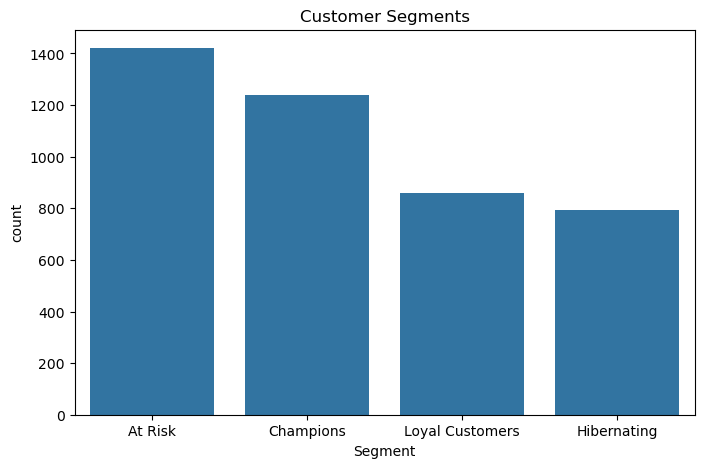

In [61]:
plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.show()

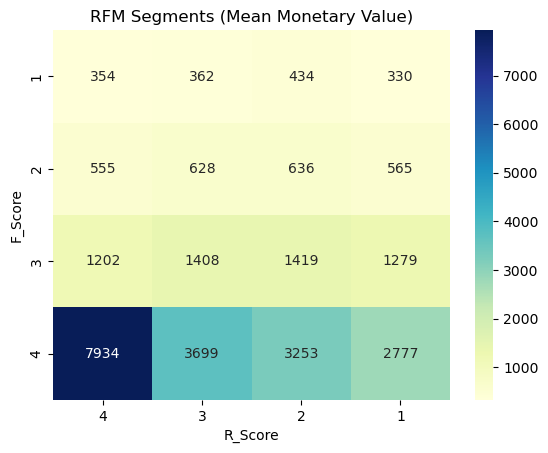

In [67]:
# Heatmap of Recency & Frequency
sns.heatmap(rfm_heatmap, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("RFM Segments (Mean Monetary Value)")
plt.show()

In [69]:
rfm.to_excel("rfm_analysis.xlsx", index=True)  # index=True keeps CustomerID